Prokash Chandra Roy

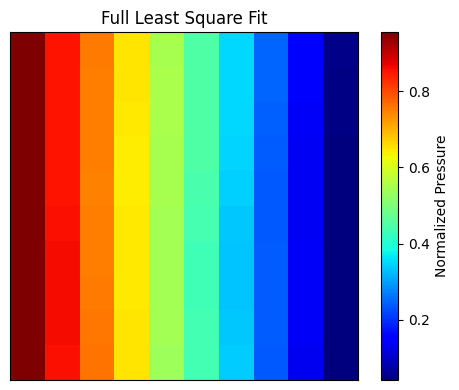

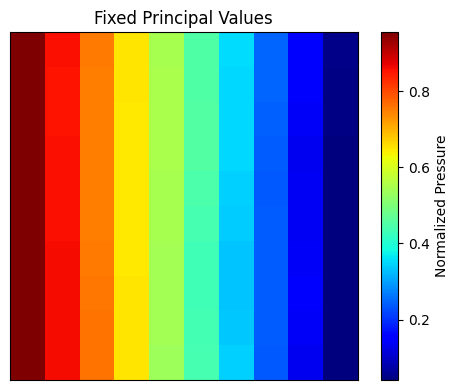

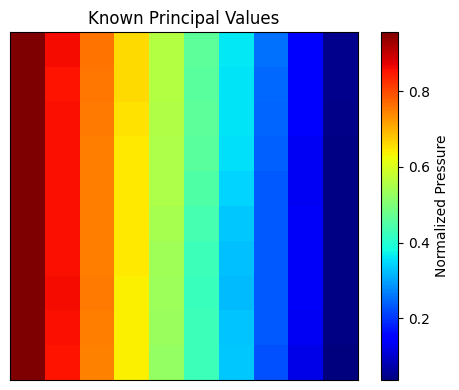

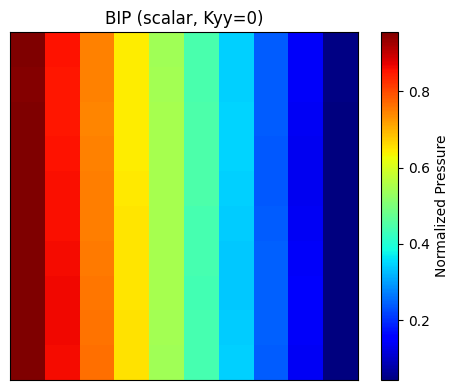

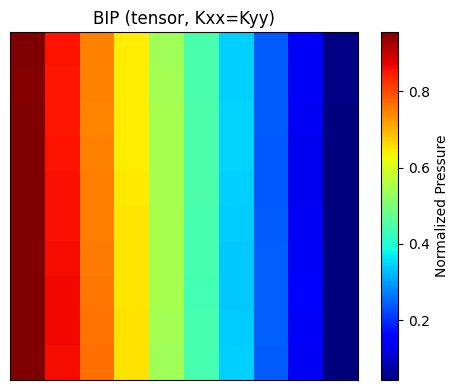


=== LBM Reference Normalization ===
Min value: 0.99988
Max value: 1.05015
Valid points: 3960000 / 6553600



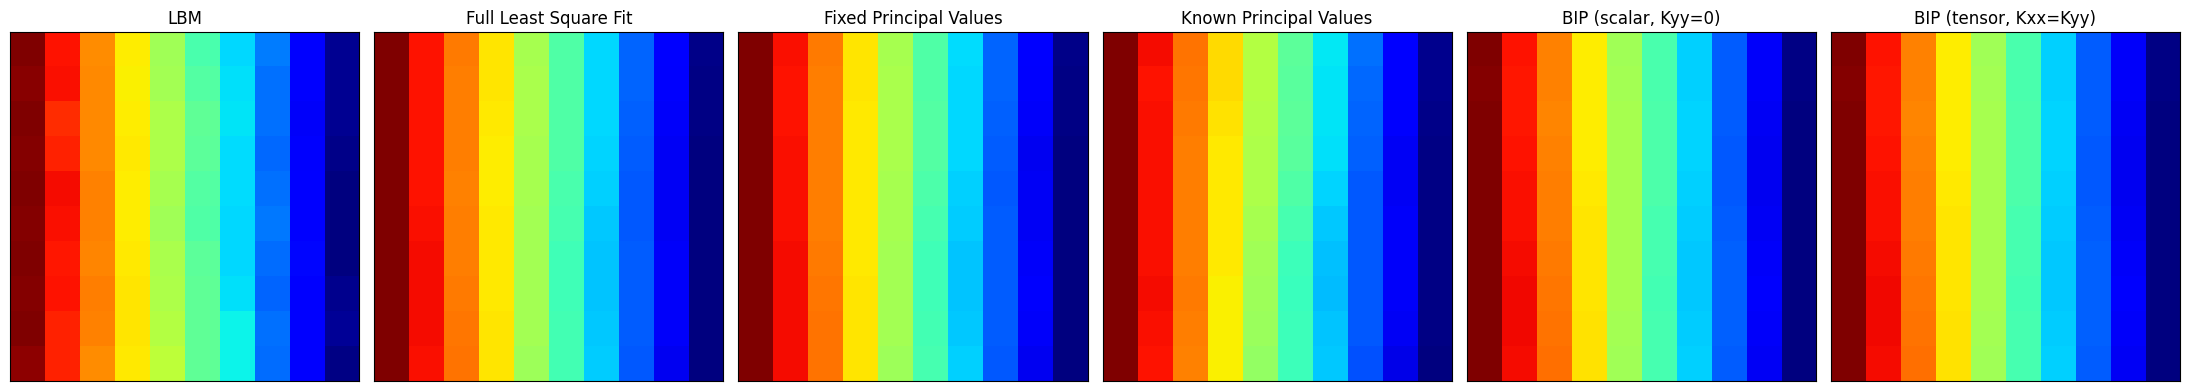


=== Error Metrics (FEM vs LBM) ===

Full Least Square Fit:
  RMSE: 1.167506e-02
  MAE:  8.672235e-03

Fixed Principal Values:
  RMSE: 1.166513e-02
  MAE:  8.614909e-03

Known Principal Values:
  RMSE: 1.521170e-02
  MAE:  1.100251e-02

BIP (scalar, Kyy=0):
  RMSE: 1.083399e-02
  MAE:  8.067606e-03

BIP (tensor, Kxx=Kyy):
  RMSE: 1.083399e-02
  MAE:  8.067606e-03


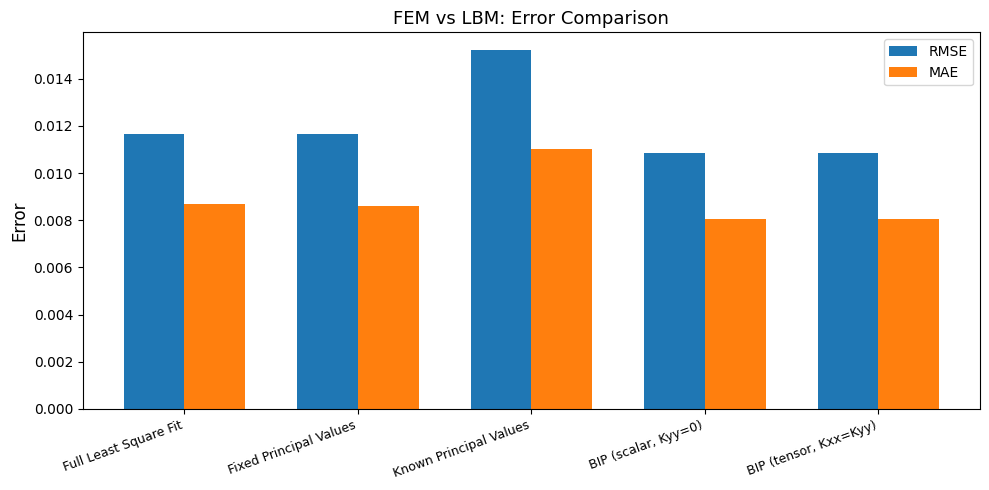

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# ============================================================
#  Helper Functions
# ============================================================

def compute_local_stiffness(element_coords, permeability_tensor):
    """
    Calculate the local stiffness matrix for a triangular element.
    
    Args:
        element_coords: Nodal coordinates of the triangle (3x2 array)
        permeability_tensor: 2x2 permeability tensor K
    
    Returns:
        3x3 local stiffness matrix
    """
    x_coords = element_coords[:, 0]
    y_coords = element_coords[:, 1]
    
    # Calculate triangle area using cross product
    area = 0.5 * abs((x_coords[1] - x_coords[0]) * (y_coords[2] - y_coords[0]) - 
                     (x_coords[2] - x_coords[0]) * (y_coords[1] - y_coords[0]))
    
    # Construct the B matrix (strain-displacement relationship)
    B_matrix = np.array([
        [y_coords[1] - y_coords[2], y_coords[2] - y_coords[0], y_coords[0] - y_coords[1]],
        [x_coords[2] - x_coords[1], x_coords[0] - x_coords[2], x_coords[1] - x_coords[0]]
    ]) / (2.0 * area)
    
    # Compute element stiffness: K_e = area * B^T * K * B
    local_K = area * B_matrix.T @ permeability_tensor @ B_matrix
    
    return local_K


def assemble_and_solve_fem(permeability_field, grid_nx, grid_ny):
    """
    Assemble the global FEM system and solve for nodal pressures.
    
    Args:
        permeability_field: Nx x Ny x 2 x 2 tensor field
        grid_nx, grid_ny: Number of elements in x and y directions
    
    Returns:
        Pressure field as (Ny+1) x (Nx+1) array
    """
    num_nodes_x = grid_nx + 1
    num_nodes_y = grid_ny + 1
    total_nodes = num_nodes_x * num_nodes_y
    
    # Define mesh spacing
    dx = 1.0 / grid_nx
    dy = 1.0 / grid_ny
    
    # Generate node coordinates
    node_coords = np.array([[i * dx, j * dy] 
                            for j in range(num_nodes_y) 
                            for i in range(num_nodes_x)])
    
    # Build element connectivity (two triangles per quad)
    element_list = []
    for j in range(grid_ny):
        for i in range(grid_nx):
            bottom_left = j * (grid_nx + 1) + i
            bottom_right = bottom_left + 1
            top_left = bottom_left + grid_nx + 1
            top_right = top_left + 1
            
            # Add two triangular elements
            element_list.append([bottom_left, bottom_right, top_right])
            element_list.append([bottom_left, top_right, top_left])
    
    # Initialize global matrices
    global_stiffness = sp.lil_matrix((total_nodes, total_nodes))
    global_force = np.zeros(total_nodes)
    
    # Assemble global stiffness matrix
    for elem in element_list:
        coords = node_coords[elem]
        
        # Determine which permeability tensor to use (element center)
        i_center = int(np.mean([elem[0] % (grid_nx + 1), 
                                elem[1] % (grid_nx + 1), 
                                elem[2] % (grid_nx + 1)]))
        j_center = int(np.mean([elem[0] // (grid_nx + 1), 
                                elem[1] // (grid_nx + 1), 
                                elem[2] // (grid_nx + 1)]))
        
        perm_tensor = permeability_field[i_center, j_center]
        elem_stiffness = compute_local_stiffness(coords, perm_tensor)
        
        # Add to global matrix
        for a in range(3):
            for b in range(3):
                global_stiffness[elem[a], elem[b]] += elem_stiffness[a, b]
    
    # Apply Dirichlet boundary conditions
    pressure = np.full(total_nodes, np.nan)
    
    # Left boundary: P = 1.05
    left_boundary_nodes = [i for i in range(total_nodes) 
                          if np.isclose(node_coords[i, 0], 0.0)]
    
    # Right boundary: P = 1.0
    right_boundary_nodes = [i for i in range(total_nodes) 
                           if np.isclose(node_coords[i, 0], 1.0)]
    
    pressure[left_boundary_nodes] = 1.05
    pressure[right_boundary_nodes] = 1.0
    
    # Identify free and fixed nodes
    free_nodes = np.where(np.isnan(pressure))[0]
    fixed_nodes = np.where(~np.isnan(pressure))[0]
    
    # Modify force vector and stiffness matrix
    modified_force = global_force[free_nodes] - global_stiffness[free_nodes][:, fixed_nodes] @ pressure[fixed_nodes]
    modified_stiffness = global_stiffness[free_nodes][:, free_nodes].tocsc()
    
    # Solve for free nodes
    pressure[free_nodes] = spla.spsolve(modified_stiffness, modified_force)
    
    return pressure.reshape((num_nodes_y, num_nodes_x))


def normalize_and_coarsen(field, target_size=10):
    """
    Normalize field to [0,1] and average down to a coarser grid.
    
    Args:
        field: Input field (fine resolution)
        target_size: Target grid size (default 10x10)
    
    Returns:
        Coarsened and normalized field
    """
    # Replace NaN with zeros
    field_clean = np.nan_to_num(field)
    
    # Normalize to [0, 1]
    field_min = field_clean.min()
    field_max = field_clean.max()
    normalized = (field_clean - field_min) / (field_max - field_min + 1e-12)
    
    # Average to coarser grid (element-centered)
    coarsened = 0.25 * (normalized[:-1, :-1] + 
                        normalized[1:, :-1] + 
                        normalized[:-1, 1:] + 
                        normalized[1:, 1:])
    
    return coarsened


def visualize_field(field_data, plot_title, save_filename):
    """Create and save a visualization of a 2D field."""
    plt.figure(figsize=(5, 4))
    plt.imshow(field_data, origin='lower', cmap='jet')
    plt.title(plot_title)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(label="Normalized Pressure")
    plt.tight_layout()
    plt.savefig(save_filename, dpi=300)
    plt.show()


def calculate_rmse(field_a, field_b):
    """Calculate root mean squared error between two fields."""
    valid_mask = ~np.isnan(field_a) & ~np.isnan(field_b)
    return np.sqrt(mean_squared_error(field_a[valid_mask], field_b[valid_mask]))


def calculate_mae(field_a, field_b):
    """Calculate mean absolute error between two fields."""
    valid_mask = ~np.isnan(field_a) & ~np.isnan(field_b)
    return mean_absolute_error(field_a[valid_mask], field_b[valid_mask])


# ============================================================
#  Load Permeability Predictions
# ============================================================

permeability_data = pd.read_csv("predicted_permeabilities.csv")
grid_size = 10
fem_results = {}

# ============================================================
# Method 1: Full Least Squares Fit (FLSF)
# ============================================================

perm_tensor_flsf = np.zeros((grid_size, grid_size, 2, 2))

for i in range(grid_size):
    for j in range(grid_size):
        tile_name = f"tile_r{i+1}_c{j+1}.tiff"
        tile_data = permeability_data[permeability_data["image_name"] == tile_name]
        
        angles_rad = np.deg2rad(tile_data["target_angle"].values)
        permeabilities = tile_data["predicted_perm"].values
        
        # Build design matrix for least squares
        design_matrix = np.column_stack([
            np.cos(angles_rad)**2,
            np.sin(angles_rad)**2,
            2 * np.sin(angles_rad) * np.cos(angles_rad)
        ])
        
        # Solve for tensor components
        Kxx, Kyy, Kxy = np.linalg.lstsq(design_matrix, permeabilities, rcond=None)[0]
        perm_tensor_flsf[i, j] = [[Kxx, Kxy], [Kxy, Kyy]]

pressure_field = assemble_and_solve_fem(perm_tensor_flsf, grid_size, grid_size)
fem_results["Full Least Square Fit"] = normalize_and_coarsen(pressure_field)

# ============================================================
# Method 2: Fixed Principal Values (FPV)
# ============================================================

perm_tensor_fpv = np.zeros((grid_size, grid_size, 2, 2))

for i in range(grid_size):
    for j in range(grid_size):
        tile_name = f"tile_r{i+1}_c{j+1}.tiff"
        tile_data = permeability_data[permeability_data["image_name"] == tile_name]
        
        angles = tile_data["target_angle"].values
        permeabilities = tile_data["predicted_perm"].values
        
        # Use 0° and 90° as principal values
        Kxx = permeabilities[angles == 0][0]
        Kyy = permeabilities[angles == 90][0]
        
        # Fit Kxy using other angles
        off_axis_mask = (angles != 0) & (angles != 90)
        angles_off_axis = np.deg2rad(angles[off_axis_mask])
        
        residual = (permeabilities[off_axis_mask] - 
                   (Kxx * np.cos(angles_off_axis)**2 + Kyy * np.sin(angles_off_axis)**2))
        
        Kxy = np.linalg.lstsq(
            (2 * np.sin(angles_off_axis) * np.cos(angles_off_axis))[:, None],
            residual,
            rcond=None
        )[0][0]
        
        perm_tensor_fpv[i, j] = [[Kxx, Kxy], [Kxy, Kyy]]

pressure_field = assemble_and_solve_fem(perm_tensor_fpv, grid_size, grid_size)
fem_results["Fixed Principal Values"] = normalize_and_coarsen(pressure_field)

# ============================================================
# Method 3: Known Principal Values (KPV)
# ============================================================

perm_tensor_kpv = np.zeros((grid_size, grid_size, 2, 2))

for i in range(grid_size):
    for j in range(grid_size):
        tile_name = f"tile_r{i+1}_c{j+1}.tiff"
        tile_data = permeability_data[permeability_data["image_name"] == tile_name]
        
        angles_deg = tile_data["target_angle"].values
        permeabilities = tile_data["predicted_perm"].values
        
        # Assume max/min are principal permeabilities
        K1 = np.max(permeabilities)
        K2 = np.min(permeabilities)
        
        # Define model and loss function
        def permeability_model(theta, phi):
            return K1 * np.cos(theta - phi)**2 + K2 * np.sin(theta - phi)**2
        
        def objective(phi):
            predicted = permeability_model(np.deg2rad(angles_deg), phi)
            return np.sum((permeabilities - predicted)**2)
        
        # Optimize for principal direction
        result = minimize(objective, x0=0.0, bounds=[(0, np.pi)])
        phi_optimal = result.x[0]
        
        # Construct tensor in x-y coordinates
        cos_phi = np.cos(phi_optimal)
        sin_phi = np.sin(phi_optimal)
        
        Kxx = K1 * cos_phi**2 + K2 * sin_phi**2
        Kyy = K1 * sin_phi**2 + K2 * cos_phi**2
        Kxy = (K1 - K2) * sin_phi * cos_phi
        
        perm_tensor_kpv[i, j] = [[Kxx, Kxy], [Kxy, Kyy]]

pressure_field = assemble_and_solve_fem(perm_tensor_kpv, grid_size, grid_size)
fem_results["Known Principal Values"] = normalize_and_coarsen(pressure_field)

# ============================================================
# Method 4: Boundary Informed Permeability (BIP - scalar)
# ============================================================

perm_tensor_bip_scalar = np.zeros((grid_size, grid_size, 2, 2))

for i in range(grid_size):
    for j in range(grid_size):
        tile_name = f"tile_r{i+1}_c{j+1}.tiff"
        tile_data = permeability_data[permeability_data["image_name"] == tile_name]
        
        # Use only the 0° measurement
        k_aligned = tile_data[tile_data["target_angle"] == 0]["predicted_perm"].values[0]
        perm_tensor_bip_scalar[i, j] = [[k_aligned, 0], [0, k_aligned]]

pressure_field = assemble_and_solve_fem(perm_tensor_bip_scalar, grid_size, grid_size)
fem_results["BIP (scalar, Kyy=0)"] = normalize_and_coarsen(pressure_field)

# ============================================================
# Method 5: Boundary Informed Permeability (BIP - tensor)
# ============================================================

perm_tensor_bip_tensor = np.zeros((grid_size, grid_size, 2, 2))

for i in range(grid_size):
    for j in range(grid_size):
        tile_name = f"tile_r{i+1}_c{j+1}.tiff"
        tile_data = permeability_data[permeability_data["image_name"] == tile_name]
        
        # Use 0° measurement for isotropic approximation
        k_aligned = tile_data[tile_data["target_angle"] == 0]["predicted_perm"].values[0]
        perm_tensor_bip_tensor[i, j] = [[k_aligned, 0], [0, k_aligned]]

pressure_field = assemble_and_solve_fem(perm_tensor_bip_tensor, grid_size, grid_size)
fem_results["BIP (tensor, Kxx=Kyy)"] = normalize_and_coarsen(pressure_field)

# Save results and create visualizations
for method_name, pressure_field in fem_results.items():
    safe_name = method_name.replace(' ', '_')
    np.save(f"fem_pressure_normalized_10x10_{safe_name}.npy", pressure_field)
    visualize_field(pressure_field, method_name, f"fem_pressure_{safe_name}_10x10.png")

# ============================================================
# Load LBM Reference Data
# ============================================================

def load_reference_data(filepath):
    """Load numpy array if it exists."""
    if os.path.exists(filepath):
        return np.load(filepath)
    print(f"⚠️  Warning: {filepath} not found.")
    return None

lbm_reference = load_reference_data("rho_X_segment_0000.npy")

if lbm_reference is not None:
    # Remove boundary layers and normalize
    lbm_reference = lbm_reference[1:-1, 1:-1]
    lbm_min = np.nanmin(lbm_reference)
    lbm_max = np.nanmax(lbm_reference)
    lbm_reference = (lbm_reference - lbm_min) / (lbm_max - lbm_min + 1e-12)
    
    valid_points = ~np.isnan(lbm_reference)
    print("\n=== LBM Reference Normalization ===")
    print(f"Min value: {lbm_min:.5f}")
    print(f"Max value: {lbm_max:.5f}")
    print(f"Valid points: {np.sum(valid_points)} / {lbm_reference.size}")
    print("====================================\n")
    
    # Coarsen to 10x10 grid
    block_size_x = lbm_reference.shape[0] // grid_size
    block_size_y = lbm_reference.shape[1] // grid_size
    lbm_coarse = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            block = lbm_reference[i*block_size_x:(i+1)*block_size_x, 
                                  j*block_size_y:(j+1)*block_size_y]
            valid_in_block = ~np.isnan(block)
            
            if np.sum(valid_in_block) == 0:
                lbm_coarse[i, j] = np.nan
            else:
                lbm_coarse[i, j] = np.nanmean(block)
else:
    lbm_coarse = None

# ============================================================
# Compare FEM Results with LBM Reference
# ============================================================

if lbm_coarse is not None:
    all_fields = {"LBM": lbm_coarse}
    all_fields.update(fem_results)
    
    # Create comparison plot
    num_fields = len(all_fields)
    plt.figure(figsize=(22, 4))
    
    for idx, (name, field) in enumerate(all_fields.items(), 1):
        plt.subplot(1, num_fields, idx)
        plt.imshow(field, cmap='jet', origin='lower')
        plt.title(name)
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig("fem_lbm_comparison_10x10_all_cases.png", dpi=300)
    plt.show()
    
    # Calculate error metrics
    rmse_results = {}
    mae_results = {}
    
    print("\n=== Error Metrics (FEM vs LBM) ===")
    for method_name, field in fem_results.items():
        rmse_results[method_name] = calculate_rmse(lbm_coarse, field)
        mae_results[method_name] = calculate_mae(lbm_coarse, field)
        
        print(f"\n{method_name}:")
        print(f"  RMSE: {rmse_results[method_name]:.6e}")
        print(f"  MAE:  {mae_results[method_name]:.6e}")
    
    # Plot error comparison
    method_labels = list(rmse_results.keys())
    x_positions = np.arange(len(method_labels))
    bar_width = 0.35
    
    plt.figure(figsize=(10, 5))
    plt.bar(x_positions - bar_width/2, 
            [rmse_results[label] for label in method_labels],
            bar_width, 
            label='RMSE')
    plt.bar(x_positions + bar_width/2, 
            [mae_results[label] for label in method_labels],
            bar_width, 
            label='MAE')
    
    plt.xticks(x_positions, method_labels, rotation=20, ha='right', fontsize=9)
    plt.ylabel("Error", fontsize=12)
    plt.title("FEM vs LBM: Error Comparison", fontsize=13)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig("fem_lbm_rmse_mae_all_cases.png", dpi=300)
    plt.show()
else:
    print("\nLBM reference data not available — skipping comparison.")